In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import os
import sys
import datetime
from subprocess import call
import subprocess
import glob
import djPyi2 as DJ
from djPyi2 import Common as CM
from djPyi2 import mpltools

from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
import pandas as pd
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy 
import pybedtools as pbt
import ciepy
import cardipspy as cpy
import itertools
import tempfile
import six
import networkx as nx
import scipy.stats as stats
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import datetime

from scipy.stats import mode
dy_name = 'ss_qc_analysis'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    cpy.makedir(private_out)

# Test Replication Rate versus VCF annotations in SpeedSeq Variants

In [2]:
def filtering_df(rr_df, info, cat, thresholds, subcat = False):
    
    def add_num_sites_total(df, info, thresholds, subcat=False):
        data = []
        for i in thresholds:
            if subcat:
                s =  info[(info[cat] >= i) & (info['SVTYPE'] == subcat)].shape[0]
            else:
                s = info[info[cat] >= i].shape[0]
            data.append(s)
        df = df.copy()
        df['num_sites_all'] = data
        return df
    
   
    dfs = []
    
    for g, df in rr_df.groupby('SVTYPE'):
        data = []
        for thresh in thresholds:
            tdf = df[(df.MSQ >= thresh) & (df.replication_rate != 'None')]
            m = tdf.replication_rate.astype(float).mean()
            s = tdf.shape[0]
            data.append([thresh, s, m, g])
    
    
            
        filtDf = pd.DataFrame(data, columns=['thresh', 'num_sites', 'mean_replication_rate', 'SVTYPE'])
        filtDf = filtDf.pipe(add_num_sites_total, info, thresholds, subcat=g)
        dfs.append(filtDf)
    
    # with no subtypes
    data = []
    for thresh in thresholds:
        tdf = rr_df[(rr_df.MSQ >= thresh) & (rr_df.replication_rate != 'None')]
        m = tdf.replication_rate.astype(float).mean()
        s = tdf.shape[0]
        data.append([thresh, s, m, 'all'])
    filtDf = pd.DataFrame(data, columns=['thresh', 'num_sites', 'mean_replication_rate', 'SVTYPE'])
    filtDf = filtDf.pipe(add_num_sites_total, info, thresholds, subcat=False)
        
    dfs.append(filtDf)
    df_out = pd.concat(dfs)
    
    
    
        
    return df_out 

In [3]:
def get_legend_patches(labels, just_lines= False, linecolor= 'black', linewidth=0, marker ='o', 
                           markeredgecolor='black', markeredgewidth=1, 
                           markerfacecolor = 'white', markersize=20):
                        
    """Function to return a list of patches with any combination of markeredgewidths, facecolors, markersizes, edgecolors- only for points and other markers- lines with or without points
    
    if lines = True- return patches of just lines from colors_lines, and labels_lines
    to insert spaces in a legend- pass a list with linewidths or markersize= 0 and label = '' for those elements
    make a legend by ax.legend(handles =patches) and adjust as desired
    
    """

    patches = []
    num_patches = len(labels)
  
    props = [markeredgecolor, markerfacecolor, markeredgewidth, markersize, marker, linewidth, linecolor]
    prop_names = ['markeredgecolor', 'markerfacecolor', 'markeredgewidth', 'markersize', 'marker', 
                  'linewidth', 'linecolor']

    for i, z in enumerate(props):
        if hasattr(z, '__iter__'): 
            assert len(z) == num_patches, 'incorrect length of list of {}'.format(prop_names[i])

        else:
            # duplicate the default into a list of length num patches- simplify patch list building below
            z = [z for l in range(num_patches)]
            props[i] = z

    markeredgecolor, markerfacecolor, markeredgewidth, markersize, marker, linewidth, linecolor = props
    
    if not just_lines:
        for i, l in enumerate(labels):
            # plot lines/markers- default to no line just marker
            p= plt.Line2D((0,0),(0,0), linewidth= linewidth[i], color= linecolor[i], 
                          markeredgecolor = markeredgecolor[i],
                          markeredgewidth= markeredgewidth[i], markerfacecolor = markerfacecolor[i], 
                          markersize=markersize[i], label= l, marker= marker[i])
            patches.append(p)
    else:
        for i, l in enumerate(labels):
            # plot a line with no markers
            p= plt.Line2D((0,0),(0,0), linewidth=linewidth[i], color=linecolor[i], label = l)
            patches.append(p)     
    return patches

In [4]:
def plot_discordance_vs_cat(df,labels, colors, thresholds, num_sites, cat, letter_label):
    min_thresh = min(thresholds)
    max_thresh = max(thresholds)
    
    
    with sns.axes_style('ticks'):
        fig, ax = plt.subplots(1,1, figsize = (8,5))
        
        # color bar plotting
        divider = make_axes_locatable(ax)
        axDivY = divider.append_axes( 'right', size=0.2, pad= 0.1)
        cmap = plt.cm.PuBu
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_thresh, vmax=max_thresh))
        sm.set_array([]) 
        cbar = plt.colorbar(sm, cax = axDivY)
        cbar.set_ticks(thresholds)
        
        patches = mpltools.get_legend_patches(labels, markeredgecolor=colors,
                                     markerfacecolor='white', markeredgewidth=2, markersize=10)
        
         
        
        for c, l in zip(colors, labels):
            tdf = df[df.SVTYPE == l]
         
            ax.scatter(tdf[num_sites], tdf.mean_replication_rate, c = tdf.thresh, cmap= cmap, lw = 1, edgecolor = c, label = l)
            
        leg = ax.legend(handles = patches, bbox_to_anchor = (1,0), loc='lower right',ncol = 1,
                             fontsize= 11, title = 'SVTYPE', frameon=True, borderaxespad=0)
        leg.get_frame().set_facecolor('white')
        leg.get_frame().set_edgecolor('black')
        plt.setp(leg.get_title(), fontsize=12, color='Black')
        
        ax.set(ylabel = 'mean replication rate', xlabel = 'number of total sites')      
        fig.text(0.98, 0.5, "{} threshold".format(cat), rotation= 90, horizontalalignment='center', verticalalignment='center', fontsize = 15)
        
        
        xlim = ax.get_xlim()
        ax.axhline(0.9, xlim[0], xlim[1], linestyle = '--', )
        
        fig.text(0.05, 0.95, "{}".format(letter_label), horizontalalignment='center', verticalalignment='center', fontsize = 18, fontweight='bold')
        return ax
        

In [5]:
def prep_rr_df(df, info):
    df = df.copy()
    df = df.join(info.MSQ.astype(float))
    df = df[df['name'].isin(info.index.tolist())]
    bnds = df[df.SVTYPE == 'BND'].copy()
    df['ID_BND'] = df['name']
    df.loc[bnds.index.tolist(), 'ID_BND'] = df['name'].apply(lambda x: x.split('_')[3]) + '_i2QTL'
    df = df.drop_duplicates('ID_BND')
    
    return df

In [6]:
def prep_info(df):
    df = df.copy()
    df['SVLEN_MOD'] = np.abs(df.SVLEN.astype(str).apply(lambda x: x.replace('Column_Not_Present', '1')).astype(int))
    # this should be fixed now in data extraction to apply the SHORT_DEL tag
    #df = df[~((df.SVTYPE=='DEL') & (df.SR==0) & (df.SVLEN_MOD < 418))]
    
    return df

In [7]:
def prep_info2(df):
    df = df.copy()
    df['SVLEN_MOD'] = np.abs(df.SVLEN.astype(str).apply(lambda x: x.replace('Column_Not_Present', '1')).astype(int))
    return df

In [210]:
# fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ss_processing_pipeline/i2QTL_V2/lumpy_info_filt.tsv'
# info2 = pd.read_table(fn, index_col=0)

In [8]:
def subset(df):
    df = df.copy()
    df = df[((df.SVTYPE=='DEL') & (df.SR==0) & (df.SVLEN_MOD < 418))]
    return df

In [9]:
fn = '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ss_processing_pipeline/i2QTL_final/lumpy_info_filt.tsv'
info = pd.read_table(fn, index_col=0).pipe(prep_info)

In [10]:
rr_per_site_twin = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ss_processing_pipeline/i2QTL_final/rr_per_site_twin.pkl').pipe(prep_rr_df, info)

In [11]:
rr_per_site_fib_ipsc = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ss_processing_pipeline/i2QTL_final/rr_per_site_fib_ipsc.pkl').pipe(prep_rr_df, info)

In [12]:
rr_per_site_fib_ipsc_filt = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ss_processing_pipeline/i2QTL_final/rr_per_site_fib_ipsc_filt.pkl').pipe(prep_rr_df, info)

In [13]:
thresholds_MSQ = list(np.arange(0, 200, 10))
fdf_twin = filtering_df(rr_per_site_twin, info, 'MSQ', thresholds_MSQ)

In [14]:
thresholds_MSQ = list(np.arange(0, 200, 10))
fdf_fib_ipsc = filtering_df(rr_per_site_fib_ipsc, info, 'MSQ', thresholds_MSQ)

In [15]:
# subsetted to iPSC pairs that are not outliers for concordance
thresholds_MSQ = list(np.arange(0, 200, 10))
fdf_fib_ipsc_filt = filtering_df(rr_per_site_fib_ipsc_filt, info, 'MSQ', thresholds_MSQ)

In [16]:
CM.save_dataframe('lumpy_filtering_MSQ_twin', fdf_twin, private_out)

lumpy_filtering_MSQ_twin = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ss_qc_analysis/lumpy_filtering_MSQ_twin.pkl')
lumpy_filtering_MSQ_twin = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ss_qc_analysis/lumpy_filtering_MSQ_twin.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ss_qc_analysis/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ss_qc_analysis/load_pickled_nb_variables.py


In [17]:
CM.save_dataframe('lumpy_filtering_MSQ_fib_ipsc', fdf_fib_ipsc, private_out)

lumpy_filtering_MSQ_fib_ipsc = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ss_qc_analysis/lumpy_filtering_MSQ_fib_ipsc.pkl')
lumpy_filtering_MSQ_fib_ipsc = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ss_qc_analysis/lumpy_filtering_MSQ_fib_ipsc.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ss_qc_analysis/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ss_qc_analysis/load_pickled_nb_variables.py


In [18]:
CM.save_dataframe('lumpy_filtering_MSQ_fib_ipsc_filt', fdf_fib_ipsc_filt, private_out)

lumpy_filtering_MSQ_fib_ipsc_filt = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ss_qc_analysis/lumpy_filtering_MSQ_fib_ipsc_filt.pkl')
lumpy_filtering_MSQ_fib_ipsc_filt = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ss_qc_analysis/lumpy_filtering_MSQ_fib_ipsc_filt.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ss_qc_analysis/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ss_qc_analysis/load_pickled_nb_variables.py


In [19]:
colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black']
labels = ['BND', 'DEL', 'DUP', 'INV', 'rMEI', 'all']

def annotate_arrows(ax, unit, offset, fdf, thresh_bnd, thresh_del, thresh_dup, thresh_inv, thresh_mei):
    
    

    filter_levels = [thresh_bnd, thresh_del, thresh_dup, thresh_inv, thresh_mei]
    categories = ['BND', 'DEL', 'DUP', 'INV', 'rMEI']
    colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255']
    
    for fl, cat, c in zip(filter_levels, categories, colors):
        x_coord, y_coord = fdf[(fdf.SVTYPE == cat) & (fdf.thresh==fl)][['num_sites_all', 'mean_replication_rate']].values[0]
        
#         x_coord, y_coord = df[df.thresh==fl][['num_sites_all', 'mean_replication_rate']].values[0]
        x_coord += offset
        x_coord2 = x_coord + unit
        
        ax.annotate('', xy=(x_coord, y_coord), xytext=(x_coord2, y_coord), arrowprops=dict(facecolor='black', width=1, shrink = 0.0, headwidth=8, frac = 0.002, color = c))

def select_filters(fdf, rr_thresh):
    filters = fdf[fdf.mean_replication_rate > rr_thresh].groupby('SVTYPE').thresh.min().to_dict()
    filters = {k:(v if v!= 0 else 20) for k,v in filters.iteritems()}
    fdf_filt = fdf.copy()
    for k,v in filters.iteritems():
        fdf_filt = fdf_filt[~((fdf_filt.SVTYPE==k) & (fdf_filt.thresh != v))]
    return fdf_filt, filters

In [20]:
fdf_filt, filters_twin = select_filters(fdf_twin, 0.9)

In [21]:
fdf_filt_ipsc, filters_fib_ipsc = select_filters(fdf_fib_ipsc, 0.9)

In [22]:
fdf_filt_ipsc_f, filters_fib_ipsc_f = select_filters(fdf_fib_ipsc_filt, 0.9)

In [162]:
print "from twins"
fdf_filt

from twins


,thresh,num_sites,mean_replication_rate,SVTYPE,num_sites_all
9,90,2029,0.906352,BND,5049
2,20,4859,0.929235,DEL,16036
10,100,479,0.906031,DUP,1786
9,90,128,0.903058,INV,234
2,20,1883,0.952680,rMEI,2432
5,50,9957,0.912406,all,26338


In [163]:
print "from fib iPSC"
fdf_filt_ipsc

from fib iPSC


,thresh,num_sites,mean_replication_rate,SVTYPE,num_sites_all
8,80,3078,0.902184,BND,5199
2,20,7870,0.950501,DEL,16036
8,80,1030,0.906589,DUP,2010
3,30,194,0.909055,INV,262
3,30,2035,0.913221,rMEI,2305
4,40,15295,0.904494,all,27037


In [164]:
print "from fib iPSC after removing outliers"
fdf_filt_ipsc_f

from fib iPSC after removing outliers


,thresh,num_sites,mean_replication_rate,SVTYPE,num_sites_all
8,80,2852,0.903250,BND,5199
2,20,7003,0.950500,DEL,16036
8,80,905,0.902779,DUP,2010
2,20,187,0.903472,INV,265
3,30,1992,0.928607,rMEI,2305
4,40,14010,0.904036,all,27037


In [136]:
filters_twin

{'BND': 90, 'DEL': 20, 'DUP': 100, 'INV': 90, 'all': 20, 'rMEI': 20}

In [166]:
colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black']
labels = ['BND', 'DEL', 'DUP', 'INV', 'rMEI', 'all']

/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property

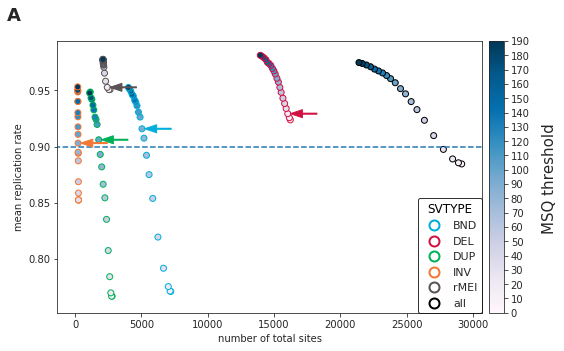

In [23]:
ax = plot_discordance_vs_cat(fdf_twin, labels, colors, thresholds_MSQ, 'num_sites_all', 'MSQ', 'A')
annotate_arrows(ax, 2000, 200, fdf_twin, 90, 20, 100, 90, 20)

/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property

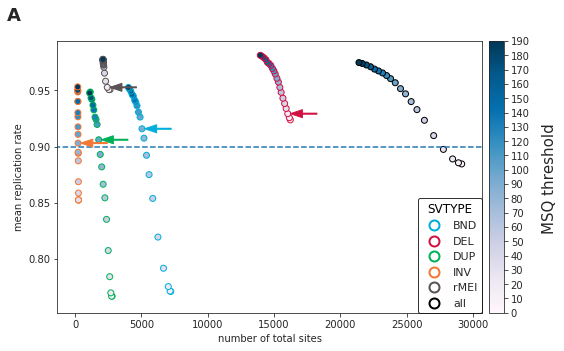

In [37]:
ax = plot_discordance_vs_cat(fdf_twin, labels, colors, thresholds_MSQ, 'num_sites_all', 'MSQ', 'A')
annotate_arrows(ax, 2000, 200, fdf_twin, 90, 20, 100, 90, 20)


/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property

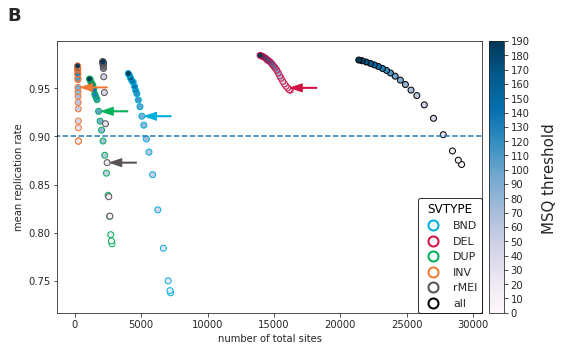

In [38]:
ax = plot_discordance_vs_cat(fdf_fib_ipsc, labels, colors, thresholds_MSQ, 'num_sites_all', 'MSQ', 'B')
annotate_arrows(ax, 2000, 200, fdf_fib_ipsc, 90, 20, 100, 90, 20)


/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property

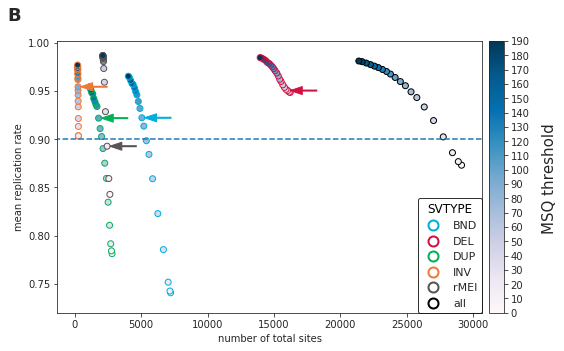

In [39]:
ax = plot_discordance_vs_cat(fdf_fib_ipsc_filt, labels, colors, thresholds_MSQ, 'num_sites_all', 'MSQ', 'B')
annotate_arrows(ax, 2000, 200, fdf_fib_ipsc_filt, 90, 20, 100, 90, 20)
